In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
pd.options.mode.chained_assignment = None
#pd.options.display.mpl_style = 'default'
from sklearn import preprocessing

from sklearn.metrics import accuracy_score, roc_curve, auc, classification_report, confusion_matrix

from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import pprint

import dateutil
%matplotlib inline

In [2]:
df = pd.read_csv("~/donorschoose/opendata_projects.csv", parse_dates = ['date_posted', 'date_completed', 'date_thank_you_packet_mailed', 'date_expiration'])

In [3]:
df.head()

,_projectid,_teacher_acctid,_schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,...,students_reached,total_donations,num_donors,eligible_double_your_impact_match,eligible_almost_home_match,funding_status,date_posted,date_completed,date_thank_you_packet_mailed,date_expiration
0,7342bd01a2a7725ce033a179d22e382d,5c43ef5eac0f5857c266baa1ccfa3d3f,9e72d6f2f1e9367b578b6479aa5852b7,3.600097e+11,40.688454,-73.910432,Brooklyn,NY,11207,urban,...,0,251,1,f,f,completed,2002-09-13,2002-09-23,2003-01-27,2003-12-31
1,b56b502d25666e29550d107bf7e17910,57426949b47700ccf62098e1e9b0220c,4a06a328dd87bd29892d73310052f45f,3.600077e+11,40.770233,-73.950760,New York,NY,10075,NaN,...,0,125,1,f,f,completed,2002-09-16,2002-09-19,2002-12-19,2003-12-31
2,3a88a47f97bd0c9b7c6a745bcd831ce3,7a20087fac86232883537cab45c0a6c9,66d08b506d2f3c30dec9e6fdb03cc279,3.600122e+11,40.729763,-73.816925,Flushing,NY,11367,urban,...,0,2110,1,f,f,completed,2002-09-17,2003-03-17,2004-06-14,2003-12-31
3,0b8a4f8eb1822ab6dd5cd9ffb918ece3,e5d28482308e2007992ae8b358b31bce,9bc7d4d92193a453669b6e2a56128e87,3.600077e+11,40.701778,-74.011840,New York,NY,10004,urban,...,0,1241,1,f,f,completed,2002-09-17,2002-09-17,2003-12-18,2003-12-31
4,45235cb116b3b35cd86d1c3a63961d7d,214d75bd0e6ce3e7085278ddd8f26daa,f7f12dee0009e6f9afa301bcca9d5070,NaN,40.815018,-73.856094,Bronx,NY,10473,urban,...,0,83,1,f,f,completed,2002-09-17,2002-09-17,2004-01-28,2003-12-31


In [4]:
#Create holdout set with projects that are still running
holdout = df[df['funding_status'] == "live"]
len(holdout)

24559

In [6]:
#Throw out reallocated and hold out set
df2 = df[df['funding_status'] != "reallocated"]
df2 = df2[df2['funding_status'] != "live"]
per_remaining = len(df2)/len(df)
print "Percent remaining: %0.2f" %(per_remaining*100)

Percent remaining: 96.28


In [8]:
len(df2['_teacher_acctid'].unique())

311981

In [11]:
df2['RESP'] = 0
df2['RESP'][df2['funding_status'] == 'completed'] = 1

In [12]:
features = df.columns.values.tolist()
for feature in features:
    per = (len(df2[feature]) - df2[feature].count())/len(df2[feature])
    if per > 0.0:
        print feature, "has %0.2f percent missing values" % (per*100)

school_ncesid has 5.57 percent missing values
school_zip has 0.00 percent missing values
school_metro has 11.23 percent missing values
school_district has 0.04 percent missing values
school_county has 0.00 percent missing values
teacher_prefix has 0.00 percent missing values
primary_focus_subject has 0.00 percent missing values
primary_focus_area has 0.00 percent missing values
secondary_focus_subject has 30.71 percent missing values
secondary_focus_area has 30.71 percent missing values
resource_type has 0.01 percent missing values
grade_level has 0.00 percent missing values
vendor_shipping_charges has 4.11 percent missing values
sales_tax has 4.11 percent missing values
payment_processing_charges has 4.11 percent missing values
fulfillment_labor_materials has 4.11 percent missing values
students_reached has 0.02 percent missing values
date_completed has 29.95 percent missing values
date_thank_you_packet_mailed has 35.63 percent missing values
date_expiration has 0.02 percent missing v

In [152]:
#TO DO
#general:    
    #decide if i should only use recent projects
    #for each column, check missing or 0 values, and decide how to handle
    #fill in urban by creating list of zips with missing and looking up
#For modeling:
    #Test different scalers
    #Test different parameters
    #Check coeffiecients to see what is important
    #Try clustering without response and print centroids - see if they are meaningful
    #Try binning continuous features
#Check distros and decide if valuable:
    #school types

In [13]:
df2['time_to_expire'] = df2.date_expiration - df2.date_posted

In [14]:
df2['amount_optional_support'] = df2.total_price_including_optional_support - df2.total_price_excluding_optional_support 
df2['optional_support'] = 0
df2['optional_support'][df2['amount_optional_support'] > 0] = 1
df2['per_optional_support'] = df2.amount_optional_support/df2.total_price_excluding_optional_support

In [15]:
df2['month'] = df2.date_posted.map(lambda x: x.month)
df2['quarter'] = df2.date_posted.map(lambda x: x.quarter)
df2['year'] = df2.date_posted.map(lambda x: x.year)

In [ ]:
df2['school_previous_projects'] = df2.groupby('_schoolid').apply(df2.date_posted.map(lambda x: len(df2[df2.date_posted < x])))

In [12]:
df2['teacher_previous_success'] = df2.groupby('_teacher_acctid')['RESP'].cumsum()-df2.RESP
df2['school_previous_success'] = df2.groupby('_schoolid')['RESP'].cumsum()-df2.RESP

In [13]:
df2['teacher_previous_projects'] = df2.groupby('_teacher_acctid').cumcount()
df2['school_previous_projects'] = df2.groupby('_schoolid').cumcount()

In [14]:
df2['teacher_per_success'] = df2['teacher_previous_success']/df2['teacher_previous_projects']
df2['school_per_success'] = df2['school_previous_success']/df2['school_previous_projects']

In [16]:
binary_features = ['school_charter',
 'school_magnet',
 'school_year_round',
 'school_nlns',
 'school_kipp',
 'school_charter_ready_promise',
'teacher_teach_for_america',
 'teacher_ny_teaching_fellow']
for feature in binary_features:
    df2[feature] = df2[feature].replace("t", 0)
    df2[feature] = df2[feature].replace("f", 1)

In [2]:
df2.head(20)

NameError: name 'df2' is not defined

In [20]:
recent_df = df2[df2['year'] >= 2014]

In [24]:
recent_df.groupby("RESP").mean()

,school_ncesid,school_latitude,school_longitude,school_zip,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,...,per_optional_support,month,quarter,year,teacher_previous_success,school_previous_success,teacher_previous_projects,school_previous_projects,teacher_per_success,school_per_success
RESP,,,,,,,,,,,,,,,,,,,,,
0,2.551986e+11,36.682192,-94.323438,54823.486280,0.918283,0.924165,0.987619,0.995434,0.996693,0.998507,...,0.176471,6.169654,2.373202,2014.250055,6.951136,42.460905,9.416592,56.313655,0.765142,0.709023
1,2.616898e+11,37.389610,-93.789516,53633.487877,0.907340,0.915454,0.989213,0.990931,0.995175,0.997841,...,0.176471,6.146859,2.368426,2014.286299,7.192170,42.644289,7.192170,42.644289,1.000000,1.000000


In [ ]:
#Charter , magnet, TFA, NYTF, school slightly more likely to get funded
#Teacher previous success, school previous success

RESP
0    Axes(0.125,0.125;0.775x0.775)
1    Axes(0.125,0.125;0.775x0.775)
Name: students_reached, dtype: object

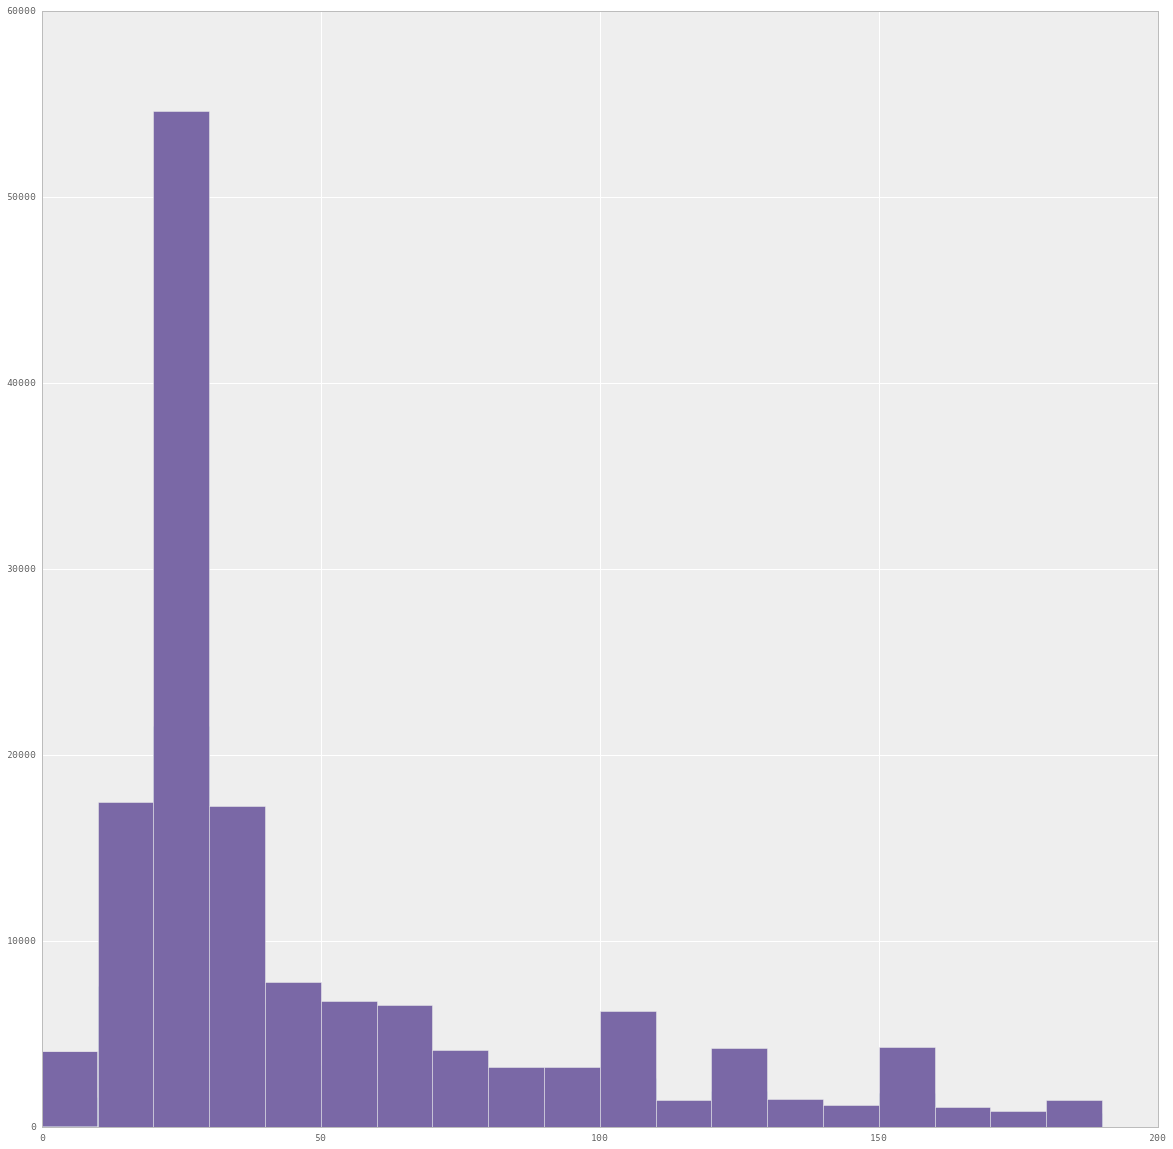

In [82]:
recent_df.groupby('RESP').students_reached.hist(alpha = 0.4, figsize = (20,20), bins = range(0, 200, 10) )

In [93]:
funded = df2[df2['RESP'] == 1]
not_funded = df2[df2['RESP'] == 0]

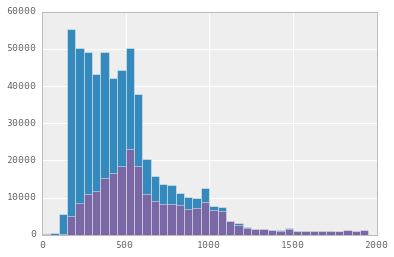

In [108]:
funded.total_price_including_optional_support.hist(bins = range (0,2000,50))
not_funded.total_price_including_optional_support.hist(bins = range (0,2000,50))

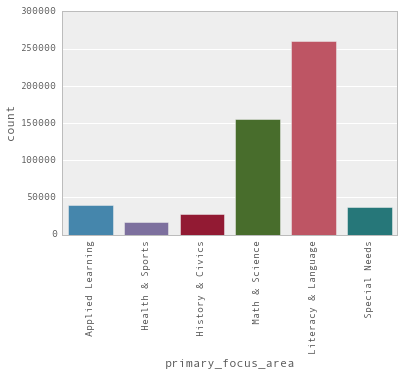

In [128]:
sns.countplot(funded.primary_focus_area, data = df2, order = ['Applied Learning', 'Health & Sports', 'History & Civics', 'Math & Science', 'Literacy & Language', 'Special Needs'])
plt.xticks(rotation = 90)
plt.show()

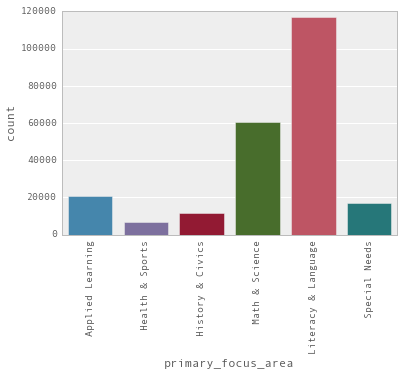

In [129]:
sns.countplot(not_funded.primary_focus_area, data = df2, order = ['Applied Learning', 'Health & Sports', 'History & Civics', 'Math & Science', 'Literacy & Language', 'Special Needs'])
plt.xticks(rotation = 90)
plt.show()

In [141]:
order = funded.grade_level.values.tolist()
order = set(order)
order = list(order)
order

[nan, 'Grades PreK-2', 'Grades 6-8', 'Grades 9-12', 'Grades 3-5']

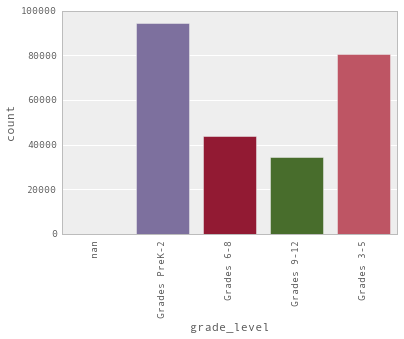

In [142]:
sns.countplot(not_funded.grade_level, data = df2, order = order)
plt.xticks(rotation = 90)
plt.show()

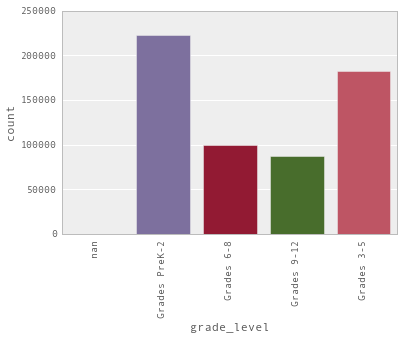

In [143]:
sns.countplot(funded.grade_level, data = df2, order = order)
plt.xticks(rotation = 90)
plt.show()

In [180]:
binary_df = binary_df[[
 'school_state',
 'school_district',
 'school_charter',
 'school_magnet',
 'school_year_round',
 'school_nlns',
 'school_kipp',
 'school_charter_ready_promise',
 'teacher_prefix',
 'teacher_teach_for_america',
 'teacher_ny_teaching_fellow',
 'primary_focus_subject',
 'primary_focus_area',
 'resource_type',
 'poverty_level',
 'grade_level',
 'total_price_including_optional_support',
 'students_reached',
 'total_donations',
 'num_donors',
 'eligible_double_your_impact_match',
 'eligible_almost_home_match',
 'funding_status',
 'date_posted',
 'date_completed',
'RESP',
 'amount_optional_support',
 'teacher_previous_success',
 'school_previous_success',
 'teacher_previous_projects',
 'school_previous_projects',
 'teacher_per_success',
 'school_per_success']]

In [181]:
binary_df.groupby("RESP").mean()

,total_price_including_optional_support,students_reached,total_donations,num_donors,amount_optional_support,teacher_previous_success,school_previous_success,teacher_previous_projects,school_previous_projects,teacher_per_success,school_per_success
RESP,,,,,,,,,,,
0,1143.857946,98.878721,77.126923,1.673130,171.578720,6.951136,42.460905,9.416592,56.313655,0.765142,0.709023
1,685.134998,91.219595,670.771993,6.103199,102.770285,7.192170,42.644289,7.192170,42.644289,1.000000,1.000000


In [182]:
binary_df.groupby("RESP").count()

,school_state,school_district,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_prefix,teacher_teach_for_america,...,funding_status,date_posted,date_completed,amount_optional_support,teacher_previous_success,school_previous_success,teacher_previous_projects,school_previous_projects,teacher_per_success,school_per_success
RESP,,,,,,,,,,,,,,,,,,,,,
0,68333,68333,68333,68333,68333,68333,68333,68333,68329,68333,...,68333,68333,0,68333,68333,68333,68333,68333,49889,66717
1,165390,165390,165390,165390,165390,165390,165390,165390,165379,165390,...,165390,165390,165390,165390,165390,165390,165390,165390,103039,155388


In [183]:
binary_df.groupby("RESP").min()

,school_state,school_district,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_prefix,teacher_teach_for_america,...,funding_status,date_posted,date_completed,amount_optional_support,teacher_previous_success,school_previous_success,teacher_previous_projects,school_previous_projects,teacher_per_success,school_per_success
RESP,,,,,,,,,,,,,,,,,,,,,
0,AK,A-c Central Cmty Unit SD 262,f,f,f,f,f,f,inf,f,...,expired,2014-01-01,NaT,12.46,0,0,0,0,0,0
1,AK,A-c Central Cmty Unit SD 262,f,f,f,f,f,f,inf,f,...,completed,2014-01-01,2014-01-01,8.88,0,0,0,0,1,1


In [184]:
binary_df.groupby("RESP").max()

,school_state,school_district,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_prefix,teacher_teach_for_america,...,funding_status,date_posted,date_completed,amount_optional_support,teacher_previous_success,school_previous_success,teacher_previous_projects,school_previous_projects,teacher_per_success,school_per_success
RESP,,,,,,,,,,,,,,,,,,,,,
0,WY,[State run],t,t,t,t,t,t,Ms.,t,...,expired,2015-08-17,NaT,14924.11,246,770,305,1170,1,1
1,WY,[State run],t,t,t,t,t,t,Ms.,t,...,completed,2015-08-17,2015-08-18,16511.28,245,769,245,769,1,1


In [186]:
binary_df.groupby("RESP").std()

,total_price_including_optional_support,students_reached,total_donations,num_donors,amount_optional_support,teacher_previous_success,school_previous_success,teacher_previous_projects,school_previous_projects,teacher_per_success,school_per_success
RESP,,,,,,,,,,,
0,1603.945589,162.364019,196.798231,2.964390,240.591852,17.166334,75.938304,22.510812,97.185991,0.26326,0.200017
1,939.842381,150.429708,923.948820,7.778545,140.976360,18.863615,74.078843,18.863615,74.078843,0.00000,0.000000


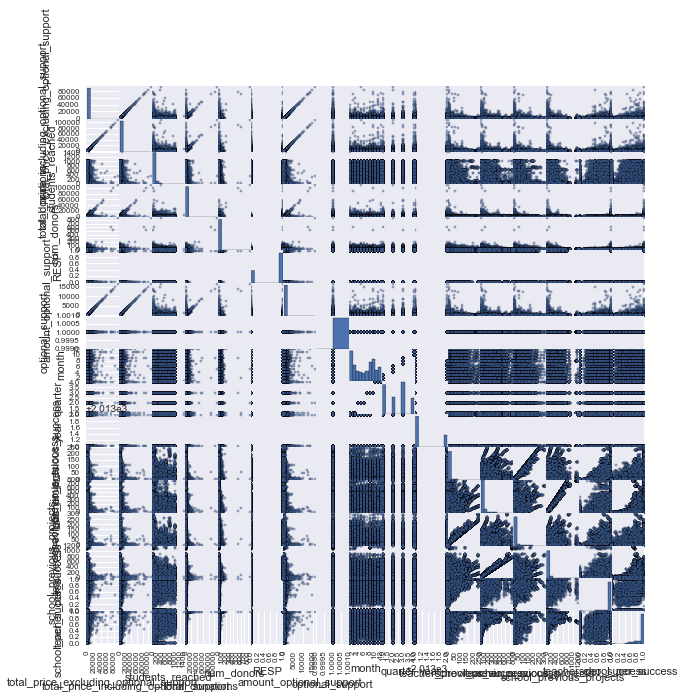

In [167]:
a = pd.scatter_matrix(binary_df,figsize=(10,10), diagonal='hist')

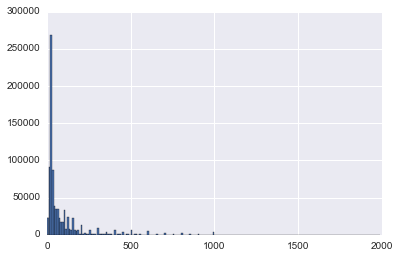

In [46]:
df2.students_reached.hist(bins=range(int(min(df2.students_reached)), 2000, 10))

In [99]:
df = df2[df2['year'] >= 2014]

In [100]:
df = df[['_projectid',
 '_teacher_acctid',
 '_schoolid',
 'school_state',
 'school_metro',
 'school_district',
 'school_charter',
 'school_magnet',
 'school_year_round',
 'school_nlns',
 'school_kipp',
 'school_charter_ready_promise',
 'teacher_prefix',
 'teacher_teach_for_america',
 'teacher_ny_teaching_fellow',
 'primary_focus_subject',
 'primary_focus_area',
 'resource_type',
 'poverty_level',
 'grade_level',
 'total_price_excluding_optional_support',
 'total_price_including_optional_support',
 'students_reached',
 'funding_status',
 'date_posted',
 'date_completed',
 'date_expiration',
 'RESP',
 'time_to_expire',
 'amount_optional_support',
 'optional_support',
 'per_optional_support',
 'month',
 'quarter',
 'teacher_previous_success',
 'school_previous_success',
 'teacher_previous_projects',
 'school_previous_projects',
 'teacher_per_success',
 'school_per_success']]

In [101]:
len(df)

233723

In [103]:
import pickle
with open('clean_data.pkl', 'w') as picklefile:
    pickle.dump(df, picklefile)

In [110]:
features

['_projectid',
 '_teacher_acctid',
 '_schoolid',
 'school_ncesid',
 'school_latitude',
 'school_longitude',
 'school_city',
 'school_state',
 'school_zip',
 'school_metro',
 'school_district',
 'school_county',
 'school_charter',
 'school_magnet',
 'school_year_round',
 'school_nlns',
 'school_kipp',
 'school_charter_ready_promise',
 'teacher_prefix',
 'teacher_teach_for_america',
 'teacher_ny_teaching_fellow',
 'primary_focus_subject',
 'primary_focus_area',
 'secondary_focus_subject',
 'secondary_focus_area',
 'resource_type',
 'poverty_level',
 'grade_level',
 'vendor_shipping_charges',
 'sales_tax',
 'payment_processing_charges',
 'fulfillment_labor_materials',
 'total_price_excluding_optional_support',
 'total_price_including_optional_support',
 'students_reached',
 'total_donations',
 'num_donors',
 'eligible_double_your_impact_match',
 'eligible_almost_home_match',
 'funding_status',
 'date_posted',
 'date_completed',
 'date_thank_you_packet_mailed',
 'date_expiration',
 'RESP',

In [207]:
clean_essays = pd.ExcelWriter('opendata_essays.csv')

ValueError: No engine for filetype: 'csv'

In [204]:
clean_essays.head()

,_projectid,_teacherid,title,short_description,need_statement,"essay, thankyou_note, impact_letter""00005f52c98eeaf92b2414a352b023a4"",""d157730073941bdd851eac950f3154e6"",""Projects Projecting into the 21st Century"",""Writing is a difficult process for many people. My sixth grade students are learning how to plan\, to edit and revise\, and to create a well-written final product. A document camera and projector..."",""My students need a document camera and projector to maximize learning in interactive and exciting ways by accessing their 21st century skills."",""Writing is a difficult process for many people. My sixth grade students are learning how to plan\, to edit and revise\, and to create a well-written final product. A document camera and projector will enable them to observe me performing this process and to edit and revise their own work with peers. \ \"
0,\\r\\n,NaN,NaN,NaN,NaN,NaN
1,I teach 110\,sixth grade students a reading class as well ...,we lack resources. Currently\,we have one document camera and projector tha...,being able to learn by seeing everything on a...,NaN
2,\\r\\n,NaN,NaN,NaN,NaN,NaN
3,"I like using the \""I do\",we do\,"you do\"" method of teaching\",so a document camera and projector that is av...,students can not only observe me practicing r...,but can also demonstrate to and observe their...
4,\\r\\n,NaN,NaN,NaN,NaN,NaN


In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

text = ["wookie stormtrooper",
        "wookie wookie wookie stormtrooper stormtrooper stormtrooper",
        "harry potter"]

vect = CountVectorizer()
data = vect.fit_transform(text).todense()

print vect.get_feature_names()
print data

print pairwise_distances(data, metric='euclidean')
print pairwise_distances(data, metric='cosine').round(2)

print 1 - pairwise_distances(data - data.mean(axis=1), metric='cosine')
print np.corrcoef(data)


[u'harry', u'potter', u'stormtrooper', u'wookie']
[[0 0 1 1]
 [0 0 3 3]
 [1 1 0 0]]
[[ 0.          2.82842712  2.        ]
 [ 2.82842712  0.          4.47213595]
 [ 2.          4.47213595  0.        ]]
[[ 0.  0.  1.]
 [ 0. -0.  1.]
 [ 1.  1.  0.]]
[[ 1.  1. -1.]
 [ 1.  1. -1.]
 [-1. -1.  1.]]
[[ 1.  1. -1.]
 [ 1.  1. -1.]
 [-1. -1.  1.]]
